<a href="https://colab.research.google.com/github/cs22m003/aes_dpa_cpa/blob/main/aes_last_round_attack_cpa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
try:
    %load_ext autotime
except:
    !pip install ipython-autotime
    %load_ext autotime

time: 453 µs (started: 2023-12-13 09:47:04 +00:00)


In [ ]:
from tqdm.notebook import tnrange
from scipy.stats import pearsonr
import pandas as pd
import numpy as np
from IPython.display import clear_output
from bokeh.io import output_notebook
from bokeh.plotting import figure, show
import os
import re

time: 3.3 s (started: 2023-12-13 09:47:09 +00:00)


In [ ]:
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ]
    return sorted(data, key=alphanum_key)

def batch_hex_txt_to_npy(dir_path,array_name):
#     filename = r'./1k-01/New folder/textin_array.txt'
    hex_string_list=[]
    file_list = sorted_alphanumeric(os.listdir(dir_path)) #1: Arrange the files for correct PT-CT match
    for file_index in tnrange(len(os.listdir(dir_path)),desc="Processing PT/CT files"):
        if(file_list[file_index].endswith(".txt")):       #2: Look for .txt files and join the dir_path to reach the file. RUNS FOR ALL FILES IN PT/CT FOLDER
            filepath = os.path.join(dir_path,file_list[file_index])
            with open (filepath,'r') as fp:               #3: OPEN EACH FILE and read all the 0-99 PT/CT keys used
                file_data_list = fp.readlines()               #READ EACH LINE, add as 1 element in the list making list of 100 elements
            for item in file_data_list:                   #4: Every element is 32 Byte Plain/Cypher text
                hex_string_list.append(item)                  #stored as hex_list for reference. it has 100 elements. HEX_STRING_LIST is MOTHER OF ALL-having all PT/CT used in traces
    for item in range(len(hex_string_list)):              #5: convert these ALL hex values to integers
        hex_string_list[item]=hex_string_list[item].split('\n')[0]  #6: new line character at the end of each line is removed here
        byte_array=[]
        for pos in range(0,len(hex_string_list[item]),2): #6: Set of TWO HEX DIGITS OF EACH ELEMENT(PT/CT)are selected & converted to integers
            byte_array.append(int(hex_string_list[item][pos:pos+2],16))   #these integer values are added to byte_array
        hex_string_list[item] = byte_array                #7: by end, EACH HEX VALUE ELEMENT is now converted to array of integers
    #hex_string_list is now a list(no. of PT/CT used from all files) of lists(each hex value PT/CT as integer array)
    npy_array=np.array(hex_string_list)                   #8: 2D array of num_traces x integer array(of each element) is generated
    np.save(f'/content/drive/MyDrive/PowerAnalysis/04-11-2023/traces/{array_name}', npy_array)

def int_trace_to_npy(dir_path,array_name):
    trace_list = []
    file_list = sorted_alphanumeric(os.listdir(dir_path)) #1: Go to trace folder. Rearrange all the files inside
    for filenum in tnrange(len(os.listdir(dir_path)),desc="Processing File"): #2: RUN THROUGH ALL THE FILES
        if(file_list[filenum].endswith(".txt")):          #3: Select each file
            filepath = os.path.join(dir_path,file_list[filenum])
            with open(filepath,'r')as fp:                 #4: Open each .txt file and read lines. Every line is an element that ends with "\n"
                wavedesc = fp.read()  # FILE FORMAT:- "\n <header values(settings info)> "\n and <power trace values after that>
            vertical_gain=0           #wavedesc is a long string of the whole textfile
            vertical_offset=0     #default values intialised
            arr=[]
            # Read HEADER SECTION for settings details
            # SKIP first double quotes(first character of wavedesc string), stop till "\n for header section (hence,[0] of the split)
            for header in wavedesc[1:].split('"\n')[0].split("\n"):   #further split each line of header and look for gain & offset values.
                if header.startswith("VERTICAL_GAIN"):
                    vertical_gain = float(header.split(':')[-1].strip()) #when found: read value after colon, strip off empty spaces and convert it to float
                if header.startswith("VERTICAL_OFFSET"):
                    vertical_offset = float(header.split(':')[-1].strip())  #same as above

            # Read EVERYTHING AFTER HEADER SECTION for POWER TRACE VALUES
            # Skip first ". split at next "\n. Everything after is the required power trace values.
            for val in wavedesc[1:].split('"\n')[-1].split("\n")[:-1]:  #further split later string at \n for each values and stop before last(empty space)
                arr.append(round(((float(val))*vertical_gain)-vertical_offset,5))
              #store each value and build an array of 12500 points for each trace file
            trace_list.append(arr)
            #trace_list is now a list(no. of trace files) of lists(float array of the power values)
    np.save(f'/content/drive/MyDrive/PowerAnalysis/04-11-2023/traces/{array_name}',np.array(trace_list))  #4: 2D array: num_traces(no. of files) x trace_array(made from each file)


time: 3.41 ms (started: 2023-12-13 09:47:19 +00:00)


#Using the functions to generate numpy arrays

The function *batch_hex_txt_to_npy* is used to convert the PT and CT files into numpy array. The file path of the txt files containing PT and CT is given as input, the second is the name of the desired numpy array. These arrays genrated are stored in traces folder.

The function *int_trace_to_npy* is used to convert the traces collected from the oscilloscope into numpy array.

In [ ]:
batch_hex_txt_to_npy(r'/content/drive/MyDrive/PowerAnalysis/04-11-2023/PT','PT_30k')
batch_hex_txt_to_npy('/content/drive/MyDrive/PowerAnalysis/04-11-2023/CT','CT_30k')

time: 450 µs (started: 2023-12-13 09:47:30 +00:00)


In [ ]:
#LONG RUN TIME IN GOOGLE COLAB, DIRECTLY USE NPY ARRAYS  FROM /content/drive/MyDrive/PowerAnalysis/30k_traces_04Nov2023/ IN THE NEXT CELLS
int_trace_to_npy('/content/drive/MyDrive/PowerAnalysis/04-11-2023/text files','trace_30k')

time: 427 µs (started: 2023-12-13 09:47:32 +00:00)


#Load the numpy arrays into variables for further calculation.

In [ ]:
textin_array = np.load('/content/drive/MyDrive/PowerAnalysis/30k_traces_04Nov2023/textin_array_04_11_2023.npy')
textout_array = np.load('/content/drive/MyDrive/PowerAnalysis/30k_traces_04Nov2023/textout_array_04_11_2023.npy')
trace_array = np.load('/content/drive/MyDrive/PowerAnalysis/30k_traces_04Nov2023/trace_array_04_11_2023-001.npy')

# print(known_keys.shape)
print(textin_array.shape)
print(textout_array.shape)
print(trace_array.shape)

(30000, 16)
(30000, 16)
(30000, 12502)
time: 46.7 s (started: 2023-12-13 09:50:02 +00:00)


In [ ]:
print(trace_array)

[[0.99233 0.9923  0.99252 ... 0.99248 0.99251 0.99245]
 [0.9923  0.99257 0.99227 ... 0.9922  0.99207 0.99236]
 [0.99239 0.9924  0.99237 ... 0.99262 0.9923  0.9926 ]
 ...
 [0.99206 0.99234 0.99226 ... 0.9928  0.9923  0.99223]
 [0.99229 0.99243 0.992   ... 0.99249 0.99232 0.99247]
 [0.99227 0.9923  0.99254 ... 0.99259 0.99253 0.99251]]
time: 4.05 ms (started: 2023-12-13 09:50:52 +00:00)


The following cell is used to display the trace collected.

In [ ]:
from bokeh.plotting import figure, show, output_notebook

# Assuming you have 10 traces in trace_array
output_notebook()
p = figure(width=1000, height=400)

# Convert range to a list for x-values (assuming x-values are the same for all traces)
x_values = list(range(len(trace_array[0])))

# Loop to plot all 10 traces
line_colors = ["blue", "red", "green", "purple", "orange", "pink", "brown", "cyan", "gray", "magenta"]
for i in range(10):
    p.line(x_values, trace_array[i*9], line_color=line_colors[i], legend_label=f"Trace {i+1}")

# Add a legend to the plot
#p.legend.location = "top_left"

show(p)



time: 528 ms (started: 2023-12-13 09:50:57 +00:00)


In [ ]:
def dec_to_hex(arr):
    s = "".join([str(hex(x)[2:]).rjust(2, "0") for x in arr])
    return s

def hex_to_dec(s):
    deci_list = []
    for i in range(0, len(s), 2):
        deci_list.append(int(s[i:i+2], 16))
    return deci_list

time: 1.29 ms (started: 2023-12-13 09:51:04 +00:00)


1. dec_to_hex(arr): This function takes a list of decimal numbers (arr) and converts each number to its hexadecimal representation. The result is a string where each hexadecimal number is represented by two characters, and the entire string is formed by concatenating these hexadecimal representations. For example, if arr is [16, 32, 255], the output would be the string "1020ff".

2.  hex_to_dec(s): This function takes a hexadecimal string (s) and converts it into a list of decimal numbers. It does so by iterating through the string with a step of 2 (since each hexadecimal number is represented by two characters), converting each substring to its decimal equivalent, and appending it to a list. For example, if s is "1020ff", the output would be the list [16, 32, 255].

In [ ]:
textin_array = np.array(textin_array, dtype = np.int32)
textout_array = np.array(textout_array, dtype = np.int32)

time: 3.87 ms (started: 2023-12-13 09:51:06 +00:00)


In [ ]:
print(textin_array[0])
print(dec_to_hex(textin_array[0]))
print(hex_to_dec(dec_to_hex(textin_array[0])))
print(dec_to_hex(textout_array[0]))

[250   2  33 229  55 210 135 206  43  55 125 229 154  73 232 254]
fa0221e537d287ce2b377de59a49e8fe
[250, 2, 33, 229, 55, 210, 135, 206, 43, 55, 125, 229, 154, 73, 232, 254]
8da01c59b6f8daab5f6c390a401c8f64
time: 2.41 ms (started: 2023-12-13 09:51:08 +00:00)


In [ ]:
def sbox(inp):
    s =  [0x63, 0x7c, 0x77, 0x7b, 0xf2, 0x6b, 0x6f, 0xc5, 0x30, 0x01, 0x67,
            0x2b, 0xfe, 0xd7, 0xab, 0x76, 0xca, 0x82, 0xc9, 0x7d, 0xfa, 0x59,
            0x47, 0xf0, 0xad, 0xd4, 0xa2, 0xaf, 0x9c, 0xa4, 0x72, 0xc0, 0xb7,
            0xfd, 0x93, 0x26, 0x36, 0x3f, 0xf7, 0xcc, 0x34, 0xa5, 0xe5, 0xf1,
            0x71, 0xd8, 0x31, 0x15, 0x04, 0xc7, 0x23, 0xc3, 0x18, 0x96, 0x05,
            0x9a, 0x07, 0x12, 0x80, 0xe2, 0xeb, 0x27, 0xb2, 0x75, 0x09, 0x83,
            0x2c, 0x1a, 0x1b, 0x6e, 0x5a, 0xa0, 0x52, 0x3b, 0xd6, 0xb3, 0x29,
            0xe3, 0x2f, 0x84, 0x53, 0xd1, 0x00, 0xed, 0x20, 0xfc, 0xb1, 0x5b,
            0x6a, 0xcb, 0xbe, 0x39, 0x4a, 0x4c, 0x58, 0xcf, 0xd0, 0xef, 0xaa,
            0xfb, 0x43, 0x4d, 0x33, 0x85, 0x45, 0xf9, 0x02, 0x7f, 0x50, 0x3c,
            0x9f, 0xa8, 0x51, 0xa3, 0x40, 0x8f, 0x92, 0x9d, 0x38, 0xf5, 0xbc,
            0xb6, 0xda, 0x21, 0x10, 0xff, 0xf3, 0xd2, 0xcd, 0x0c, 0x13, 0xec,
            0x5f, 0x97, 0x44, 0x17, 0xc4, 0xa7, 0x7e, 0x3d, 0x64, 0x5d, 0x19,
            0x73, 0x60, 0x81, 0x4f, 0xdc, 0x22, 0x2a, 0x90, 0x88, 0x46, 0xee,
            0xb8, 0x14, 0xde, 0x5e, 0x0b, 0xdb, 0xe0, 0x32, 0x3a, 0x0a, 0x49,
            0x06, 0x24, 0x5c, 0xc2, 0xd3, 0xac, 0x62, 0x91, 0x95, 0xe4, 0x79,
            0xe7, 0xc8, 0x37, 0x6d, 0x8d, 0xd5, 0x4e, 0xa9, 0x6c, 0x56, 0xf4,
            0xea, 0x65, 0x7a, 0xae, 0x08, 0xba, 0x78, 0x25, 0x2e, 0x1c, 0xa6,
            0xb4, 0xc6, 0xe8, 0xdd, 0x74, 0x1f, 0x4b, 0xbd, 0x8b, 0x8a, 0x70,
            0x3e, 0xb5, 0x66, 0x48, 0x03, 0xf6, 0x0e, 0x61, 0x35, 0x57, 0xb9,
            0x86, 0xc1, 0x1d, 0x9e, 0xe1, 0xf8, 0x98, 0x11, 0x69, 0xd9, 0x8e,
            0x94, 0x9b, 0x1e, 0x87, 0xe9, 0xce, 0x55, 0x28, 0xdf, 0x8c, 0xa1,
            0x89, 0x0d, 0xbf, 0xe6, 0x42, 0x68, 0x41, 0x99, 0x2d, 0x0f, 0xb0,
            0x54, 0xbb, 0x16]
    return s[inp]

def invsbox(inp):
    s = [0x52, 0x09, 0x6a, 0xd5, 0x30, 0x36, 0xa5, 0x38, 0xbf, 0x40, 0xa3,
            0x9e, 0x81, 0xf3, 0xd7, 0xfb , 0x7c, 0xe3, 0x39, 0x82, 0x9b, 0x2f,
            0xff, 0x87, 0x34, 0x8e, 0x43, 0x44, 0xc4, 0xde, 0xe9, 0xcb , 0x54,
            0x7b, 0x94, 0x32, 0xa6, 0xc2, 0x23, 0x3d, 0xee, 0x4c, 0x95, 0x0b,
            0x42, 0xfa, 0xc3, 0x4e , 0x08, 0x2e, 0xa1, 0x66, 0x28, 0xd9, 0x24,
            0xb2, 0x76, 0x5b, 0xa2, 0x49, 0x6d, 0x8b, 0xd1, 0x25 , 0x72, 0xf8,
            0xf6, 0x64, 0x86, 0x68, 0x98, 0x16, 0xd4, 0xa4, 0x5c, 0xcc, 0x5d,
            0x65, 0xb6, 0x92 , 0x6c, 0x70, 0x48, 0x50, 0xfd, 0xed, 0xb9, 0xda,
            0x5e, 0x15, 0x46, 0x57, 0xa7, 0x8d, 0x9d, 0x84 , 0x90, 0xd8, 0xab,
            0x00, 0x8c, 0xbc, 0xd3, 0x0a, 0xf7, 0xe4, 0x58, 0x05, 0xb8, 0xb3,
            0x45, 0x06 , 0xd0, 0x2c, 0x1e, 0x8f, 0xca, 0x3f, 0x0f, 0x02, 0xc1,
            0xaf, 0xbd, 0x03, 0x01, 0x13, 0x8a, 0x6b , 0x3a, 0x91, 0x11, 0x41,
            0x4f, 0x67, 0xdc, 0xea, 0x97, 0xf2, 0xcf, 0xce, 0xf0, 0xb4, 0xe6,
            0x73 , 0x96, 0xac, 0x74, 0x22, 0xe7, 0xad, 0x35, 0x85, 0xe2, 0xf9,
            0x37, 0xe8, 0x1c, 0x75, 0xdf, 0x6e , 0x47, 0xf1, 0x1a, 0x71, 0x1d,
            0x29, 0xc5, 0x89, 0x6f, 0xb7, 0x62, 0x0e, 0xaa, 0x18, 0xbe, 0x1b ,
            0xfc, 0x56, 0x3e, 0x4b, 0xc6, 0xd2, 0x79, 0x20, 0x9a, 0xdb, 0xc0,
            0xfe, 0x78, 0xcd, 0x5a, 0xf4 , 0x1f, 0xdd, 0xa8, 0x33, 0x88, 0x07,
            0xc7, 0x31, 0xb1, 0x12, 0x10, 0x59, 0x27, 0x80, 0xec, 0x5f , 0x60,
            0x51, 0x7f, 0xa9, 0x19, 0xb5, 0x4a, 0x0d, 0x2d, 0xe5, 0x7a, 0x9f,
            0x93, 0xc9, 0x9c, 0xef , 0xa0, 0xe0, 0x3b, 0x4d, 0xae, 0x2a, 0xf5,
            0xb0, 0xc8, 0xeb, 0xbb, 0x3c, 0x83, 0x53, 0x99, 0x61 , 0x17, 0x2b,
            0x04, 0x7e, 0xba, 0x77, 0xd6, 0x26, 0xe1, 0x69, 0x14, 0x63, 0x55,
            0x21, 0x0c, 0x7d]
    return s[inp]

"""  [0 4 8   12  after shift rows positions are [0  4  8   12
      1 5 9   13                                  5  9  13   1
      2 6 10  14                                  10 14  2   6
      3 7 11  15                                  15  3  7   11]"""
# As the rows were shifted during encryption, to revert the process we need to find the previous position of the bytes.
# INVSHIFT_undo is an array to point to the present position of the bytes

INVSHIFT_undo = [0, 5, 10, 15, 4, 9, 14, 3, 8, 13, 2, 7, 12, 1, 6, 11]

def invshiftRows(pt, keyguess, bnum):   #1: We xor round key 10 with cypher text to reach the last ADDROUNDKEY output
    return pt[bnum] ^ keyguess          #normally this would have been reached after SUB BYTE AND SHIFTROW FOR ROUND 10.

""" We need to find the data dependent behavior. so we choose  """

def intermediate(pt, keyguess, bnum, HD): #2: Th
    if HD:
        return invsbox(invshiftRows(pt, keyguess, bnum)) ^ pt[INVSHIFT_undo[bnum]]
    else:
        return invsbox(invshiftRows(pt, keyguess, bnum))

# def leakage_1(ct, key, bnum):
#     st9 = invsbox(ct[bnum] ^ key)
#     # return (st9 ^ st10)
#     return st9

# def leakage_2(ct, key, bnum):
#     st10 = ct[INVSHIFT_undo[bnum]]
#     st9 = invsbox(ct[bnum] ^ key)
#     return (st9 ^ st10)

# def intermediate(ct, key, bnum):
#     return leakage_2(ct, key, bnum)

HW = [bin(n).count("1") for n in range(0, 256)]

time: 2.56 ms (started: 2023-12-13 09:51:10 +00:00)


In [ ]:
fmt = "{:02X}<br>{:.3f}<br>{:}"
def format_stat(stat):
    return str(fmt.format(stat[0], stat[1], stat[2]))

def color_corr_key(row):
    ret = [""] * len(row)
    for i, bnum in enumerate(row):
        if i == 0:
            ret[i] = "color: green"
        else:
            ret[i] = "color: red"
    return ret

time: 976 µs (started: 2023-12-13 09:51:13 +00:00)


In [ ]:
def getroundkey(startTime, endTime, text_array, numtraces, corr_rk):
    roundkey_guess = []                                                 #1: Array to store the 16 Bytes key guess

    totaltraces = trace_array.shape[0]                                  #2: Number of samples
    # numtraces = 20_000
    numpoints = trace_array.shape[1]                                    #3: Number of points in each sample (in time domain)

    start_point = startTime                                             #4: window of points to analyze. It is to speed up the execution time
    end_point = endTime

    bigR_matrix = np.zeros((16, 256, numpoints))                        #5: 16 subkeys * 256 possibilities od each key * points with higher co relation

    H_matrix = np.zeros((numtraces, 256), dtype = np.float32)

    # for printing the top guessed keys
    printable = []

    for subkey in tnrange(0, 16, desc="Attacking Subkey"):
        temp = []
        for kguess in tnrange(0, 256, desc="Generating Hamming Weights"):
            for trace_no in range(numtraces):
                iv = intermediate(text_array[trace_no], kguess, subkey, True)
                H_matrix[trace_no, kguess] = HW[iv]

            for point in range(start_point, end_point):
                hw = H_matrix[:numtraces, kguess]
                trc = trace_array[:numtraces, point]
                if (np.var(hw, ddof = 1) == 0) or (np.var(trc, ddof = 1) == 0):
                    if (np.var(hw, ddof = 1) == 0) and (np.var(trc, ddof = 1) == 0):
                        print("Hi")
                    elif (np.var(hw, ddof = 1) == 0):
                        print("HW")
                    else:
                        print("TRC")
                    bigR_matrix[subkey, kguess, point] = 0
                else:
                    bigR_matrix[subkey, kguess, point] = np.abs(pearsonr(hw, trc)[0])

            temp.append((kguess, np.max(bigR_matrix[subkey, kguess]), np.argmax(bigR_matrix[subkey, kguess])))

        temp[0], temp[corr_rk[subkey]] = temp[corr_rk[subkey]], temp[0]
        temp1 = temp[1:]
        temp1.sort(key = lambda x: -x[1])
        temp[1:] = temp1
        printable.append(temp)
        df = pd.DataFrame(printable).transpose()

        roundkey_guess.append(bigR_matrix[subkey].max(axis = 1).argmax())

        # clears previous output
        clear_output(wait=True)
        display(df.head().style.format(format_stat).apply(color_corr_key, axis = 0))

    return roundkey_guess, bigR_matrix

time: 5.41 ms (started: 2023-12-13 09:51:15 +00:00)


#Trying with samples: 3000


In [ ]:
roundkey10_guess = getroundkey(startTime = 10_000, endTime = 10_500, text_array = textout_array, numtraces = 3_000, corr_rk = hex_to_dec('13111d7fe3944a17f307a78b4d2b30c5'))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,130.08710129,110.12010152,1D0.07210133,7F0.11410134,E30.08510130,940.10410132,4A0.11210153,170.08810131,F30.09110154,070.10910133,A70.09810130,8B0.10810131,4D0.14110134,2B0.08210155,300.09810134,C50.09410128
1,F20.08010060,8E0.08510451,300.08310097,B20.08110344,A90.07610342,840.07910253,A80.09310271,A30.08610368,780.09310011,9E0.08810267,550.08510036,0F0.08310438,F40.07910399,530.08610106,C80.07710194,F80.08010276
2,7B0.07710403,3D0.08110284,FE0.08310131,EA0.07810290,5F0.07610112,090.07610429,040.09010136,F40.08210145,4C0.08510316,110.07810261,610.08210383,1A0.08110401,390.07910450,4C0.08310116,AA0.07410284,F90.07410060
3,BE0.07710004,E50.07910414,F70.08110436,F10.07610431,6D0.07410241,AA0.07410260,B30.08110470,800.07910085,BC0.08110164,AD0.07810398,7E0.08010096,620.08010440,030.07910424,150.07910390,CA0.07310010,810.07410149
4,060.07710148,B90.07910462,710.07810199,910.07510147,0F0.07410088,B50.07310006,540.08110465,550.07510004,320.08110272,8B0.07710466,620.07510367,B30.07210356,7D0.07910020,CF0.07710194,2E0.07210461,FC0.07410409


time: 59min 54s (started: 2023-12-13 09:51:20 +00:00)


In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [ ]:
dictionary={"x":[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,25,30],"y_1":[0.112,0.092,0.1,.0815,.08534,0.0935,0.092,.091,.0889,0.0877,0.0869,0.0854,0.0786,0.0781,0.0783,0.078,0.077,0.077,0.078,0.0780,0.0773,0.0766],"y_2":[0.146,0.1,.083375,0.0725,.06594,0.059,.0566,0.0495,0.0501,0.0483,0.0466,0.0456,0.0396,0.0393,0.0372,0.036,0.040,0.034,0.032,0.0327,0.0301,0.0292]}

In [ ]:
df=pd.DataFrame(dictionary)
df

,x,y_1,y_2
0,1,0.11200,0.146000
1,2,0.09200,0.100000
2,3,0.10000,0.083375
3,4,0.08150,0.072500
4,5,0.08534,0.065940
5,6,0.09350,0.059000
6,7,0.09200,0.056600
7,8,0.09100,0.049500
8,9,0.08890,0.050100
9,10,0.08770,0.048300


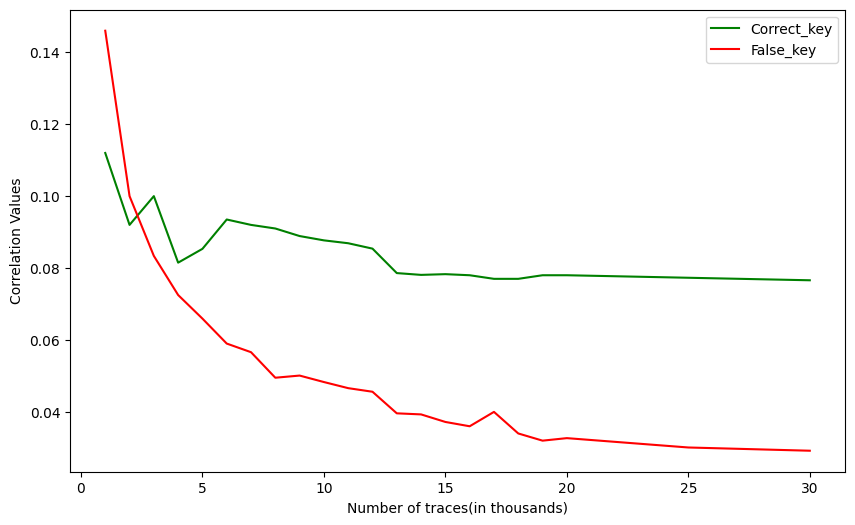

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(df["x"],df["y_1"],color="green")
plt.plot(df["x"],df["y_2"],color="red")
plt.legend(["Correct_key","False_key"])
plt.xlabel("Number of traces(in thousands)")
plt.ylabel("Correlation Values")
plt.show()

In [ ]:
%unload_ext autotime